In [2]:
import os
import time

import spacy
import networkx as nx
import matplotlib.pyplot as plt
import yaml

from openai import OpenAI

from pydantic import BaseModel


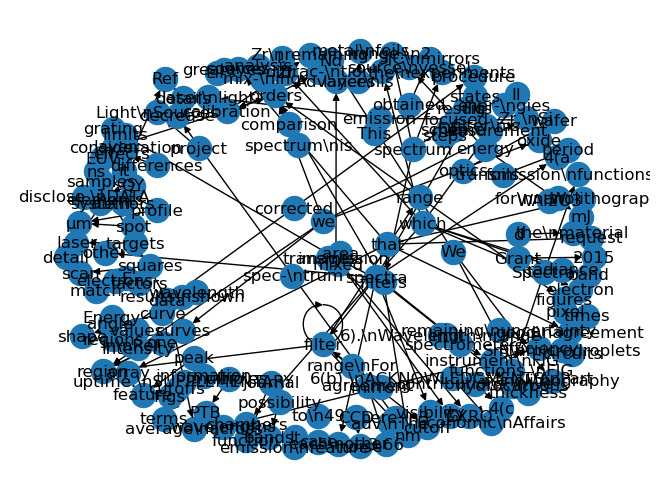

In [5]:

nlp = spacy.load("en_core_web_sm")

def get_entities_and_relations(text):
    doc = nlp(text)
    # Basic: extract subject-verb-object (tune pattern for your data)
    for sent in doc.sents:
        subject = ""
        obj = ""
        verb = ""
        for token in sent:
            if "subj" in token.dep_:
                subject = token.text
            if "obj" in token.dep_:
                obj = token.text
            if token.dep_ == "ROOT":
                verb = token.lemma_
        if subject and obj and verb:
            yield (subject, verb, obj)

G = nx.DiGraph()

with open("/Users/jamesbyers/code/github/knowledge_graphs/data/processed/2021Bouza_txt_only.txt", "r") as file:
    text = file.read()
# sample_text = "The Zr filter blocks second-order diffraction. The SiC filter enables measurement in the 40-115 nm range."
for s, v, o in get_entities_and_relations(text):
    G.add_edge(s, o, label=v)

nx.draw(G, with_labels=True)
plt.show()


In [9]:
def get_openai_key(path_to_secrets):
    openai_api_key = None
    try:
        with open(path_to_secrets, "r") as file:
            secrets = yaml.safe_load(file)
            openai_api_key = secrets["openai_api_key"]
    except Exception as e:
        print(f"[ERROR]: {e}")

    return openai_api_key

OPENAI_API_KEY = get_openai_key(os.path.join(os.getcwd(), ".secrets.yml"))

In [45]:
from typing import List, Tuple

class SRO(BaseModel):
    SRO: Tuple[str, str, str]   # This matches a 3-item tuple

class ExtractionTemplate(BaseModel):
    SRO: List[SRO]
    # subject: list[str]
    # relation: list[str]
    # object: list[str]


prompt = f"""
Extract all relevant (subject, relation, object) triples from the following scientific text, focusing on physical components, processes, measurements, and diagnostics. Be domain-aware and avoid generic entities ("it", "we"). Present results as a list of triples in the form (subject, relation, object), so that I can build a knowledge graph.

Text:
{text}
"""

client = OpenAI(api_key=OPENAI_API_KEY)

model = "gpt-4.1-mini"

messages=[
        {"role": "user", "content": prompt},
    ]

start = time.perf_counter()
response = client.responses.parse(
    model="gpt-4.1-mini",
    input=messages,
    text_format=ExtractionTemplate
)
end = time.perf_counter()


BadRequestError: Error code: 400 - {'error': {'message': "Invalid schema for response_format 'ExtractionTemplate': In context=('properties', 'SRO'), array schema missing items.", 'type': 'invalid_request_error', 'param': 'text.format.schema', 'code': 'invalid_json_schema'}}

In [44]:
response_dict = response.output_parsed.model_dump()
# for key, value in response_dict.items():
#     print(key, value)

print(len(response_dict["subject"]))
print(len(response_dict["relation"]))
print(len(response_dict["object"]))

KeyError: 'subject'

In [ ]:
from pydantic import BaseModel
from typing import List, Tuple
import time
import json

class SRO(BaseModel):
    SRO: Tuple[str, str, str]

class ExtractionTemplate(BaseModel):
    SRO: List[SRO]

prompt = f"""
Extract all relevant (subject, relation, object) triples from the following scientific text, focusing on physical components, processes, measurements, and diagnostics. Avoid generic entities like "it" or "we".

Return the output strictly as valid JSON, matching this schema:
{{
  "SRO": [
    {{"SRO": ["subject", "relation", "object"]}},
    ...
  ]
}}
Text:
{text[:1000]}
"""

start = time.perf_counter()
response = client.chat.completions.parse(
    model=model,
    messages=[{"role": "user", "content": prompt}],
    
)
end = time.perf_counter()

raw = response.choices[0].message.content
try:
    data = json.loads(raw)
    validated = ExtractionTemplate.model_validate(data)
    print(validated)
except Exception as e:
    print("Validation error:", e)
    print("Raw output was:", raw)


BadRequestError: Error code: 400 - {'error': {'message': "Invalid schema for response_format 'SRO': In context=('properties', 'SRO'), array schema missing items.", 'type': 'invalid_request_error', 'param': 'response_format', 'code': None}}

In [54]:
??client.chat.completions.parse

Signature:
client.chat.completions.parse(
    *,
    messages: 'Iterable[ChatCompletionMessageParam]',
    model: 'Union[str, ChatModel]',
    audio: 'Optional[ChatCompletionAudioParam] | NotGiven' = NOT_GIVEN,
    response_format: 'type[ResponseFormatT] | NotGiven' = NOT_GIVEN,
    frequency_penalty: 'Optional[float] | NotGiven' = NOT_GIVEN,
    function_call: 'completion_create_params.FunctionCall | NotGiven' = NOT_GIVEN,
    functions: 'Iterable[completion_create_params.Function] | NotGiven' = NOT_GIVEN,
    logit_bias: 'Optional[Dict[str, int]] | NotGiven' = NOT_GIVEN,
    logprobs: 'Optional[bool] | NotGiven' = NOT_GIVEN,
    max_completion_tokens: 'Optional[int] | NotGiven' = NOT_GIVEN,
    max_tokens: 'Optional[int] | NotGiven' = NOT_GIVEN,
    metadata: 'Optional[Metadata] | NotGiven' = NOT_GIVEN,
    modalities: "Optional[List[Literal['text', 'audio']]] | NotGiven" = NOT_GIVEN,
    n: 'Optional[int] | NotGiven' = NOT_GIVEN,
    parallel_tool_calls: 'bool | NotGiven' = NOT_GIVE

In [ ]:

raw = response.choices[0].message.content
try:
    data = json.loads(raw)
    validated = ExtractionTemplate.model_validate(data)
    print(validated)
except Exception as e:
    print("Validation error:", e)
    print("Raw output was:", raw)


In [51]:
from pydantic import BaseModel
from openai import OpenAI

client = OpenAI(api_key=OPENAI_API_KEY)

class CalendarEvent(BaseModel):
    name: str
    date: str
    participants: list[str]

completion = client.chat.completions.parse(
    model="gpt-4o-2024-08-06",
    messages=[
        {"role": "system", "content": "Extract the event information."},
        {"role": "user", "content": "Alice and Bob are going to a science fair on Friday."},
    ],
    response_format=CalendarEvent,
)

event = completion.choices[0].message.parsed

In [61]:
class TestFormat(BaseModel):
    # name: List[Tuple]
    date: str
    participants: list[str]

response = client.responses.parse(
        model="gpt-4.1-mini",
        input=messages,
        text_format=TestFormat
    )

In [58]:
rdict = response.output_parsed.model_dump()
print(rdict)

{'name': 'Scientific Text Triples Extraction', 'date': '2024-06-17', 'participants': ['(microdroplet-tin Nd:YAG-laser-produced plasma, produces, EUV light at 13.5 nm)', '(transmission grating spectrometer, records, plasma emission spectrum)', '(Zr, Si, Al thin-foil filters, enable, elimination of higher diffraction orders)', '(LiF, MgF2, UV fused silica filters, support, spectral measurements in 115–265.5 nm range)', '(SiC mirrors, enable, recording of 40–100 nm wavelength range)', '(laser-produced plasma, generated by, 1-μm Nd:YAG laser pulses)', '(liquid tin microdroplets, serve as, target for plasma generation)', '(pre-pulse laser (PP), irradiates, molten tin microdroplets)', '(main pulse laser (MP), irradiates, tin target after deformation by PP)', '(PP energy, set to, 6.8 mJ)', '(MP energy, set to, 293 mJ)', '(PP pulse wavelength, is, 1 μm)', '(MP pulse wavelength, is, 1 μm)', '(PP temporal profile, Gaussian, FWHM 29 ns)', '(MP temporal profile, Gaussian, FWHM 10 ns)', '(PP beam s

In [ ]:
from openai import OpenAI
from pydantic import BaseModel

client = OpenAI(api_key=OPENAI_API_KEY)

class SubjectRelationObject(BaseModel):
    subject_relation_object: list[str]

class ExtractionTemplate(BaseModel):
    subject_relation_object: list[SubjectRelationObject]

response = client.responses.parse(
    model="gpt-4.1-nano",
    input=messages,
    # [
    #     {"role": "system", "content": "Extract the event information."},
    #     {
    #         "role": "user",
    #         "content": "Alice and Bob are going to a science fair on Friday.",
    #     },
    # ],
    text_format=ExtractionTemplate,
)

rdict = response.output_parsed.model_dump()


In [73]:
event

ExtractionTemplate(subject_relation_object=[SubjectRelationObject(subject_relation_object=['tin microdroplet plasma source', 'produces', 'extreme ultraviolet (EUV) light']), SubjectRelationObject(subject_relation_object=['spectrum', 'obtained using', 'custom-built transmission grating spectrometer']), SubjectRelationObject(subject_relation_object=['filters', 'used for calibration of', 'spectrum']), SubjectRelationObject(subject_relation_object=['filter materials', 'include', 'Zr, Si, and Al thin-foils, bulk LiF, MgF2, and UV fused silica']), SubjectRelationObject(subject_relation_object=['SiC mirrors', 'used to record', '40–100 nm range']), SubjectRelationObject(subject_relation_object=['corrected spectra', 'match in', 'overlap regions']), SubjectRelationObject(subject_relation_object=['laser-produced plasma', 'generated from', 'liquid tin (Sn) microdroplets']), SubjectRelationObject(subject_relation_object=['emission peak', 'near', '13.5 nm']), SubjectRelationObject(subject_relation_o